Loading MNIST dataset...
Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(48999, 784) (10500, 784) (10501, 784) float64
(48999,) (10500,) (10501,) int64


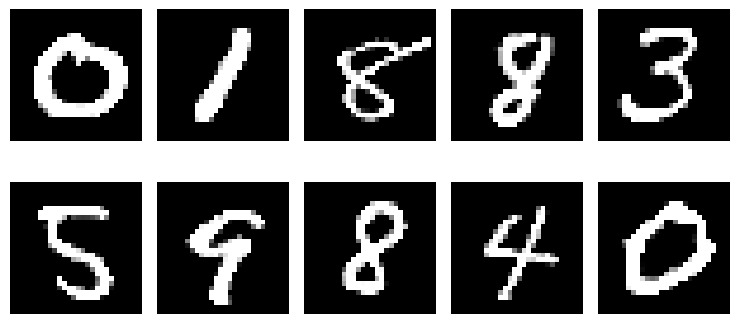

[I 2025-10-30 06:51:35,759] A new study created in memory with name: no-name-192eaf03-113f-45b7-a0f0-48597f804bb8


Epoch 5/20 - Train Loss: 1.9771 | Val Loss: 0.4133


Epoch 10/20 - Train Loss: 1.4341 | Val Loss: 0.3288


[W 2025-10-30 06:59:45,571] Trial 0 failed with parameters: {'n_layers': 2, 'n_units_l0': 126, 'n_units_l1': 131, 'lr': 0.0018758684916965187, 'batch_size': 64, 'dropout_l0': 0.04287580447254946, 'dropout_l1': 0.018080365979805557, 'weight_decay': 0.006399417919831835, 'optimizer': 'momentum', 'stopping_patience': 3, 'activation_l0': 'leaky_relu', 'activation_l1': 'sigmoid', 'momentum': 0.8203598564607232, 'step_size': 14.181965456354856, 'gamma': 0.39242605819935683} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_56534/1141066968.py", line 357, in objective
    model = train_model(
        X_train, y_train,
    ...<3 lines>...
        print_every=5, plot_loss=False
    )
  File "/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/

KeyboardInterrupt: 

In [3]:
# ===============================
# Deep Neural Network using Tensorflow with more complex features
# Dataset: MNIST (Handwritten Digit Recognition)
# ===============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from typing import List, Optional, Tuple
from functools import partial
import optuna
from dataclasses import dataclass
from tqdm import tqdm

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)


# =======================================
# 1. Load and Preprocess Data
# =======================================
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Sizes must sum to 1"

    # First split: train vs temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=random_state, stratify=y)

    # Compute proportion of validation relative to temp
    val_prop = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_prop), random_state=random_state, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Usage:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)
print(X_train.shape, X_val.shape, X_test.shape,  X_train.dtype)
print(y_train.shape, y_val.shape, y_test.shape,  y_train.dtype)
input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))
show_images(X_train)


# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tf_dataset(X, y, batch_size=64, shuffle=True):
    X_tensor = tf.cast(X, tf.float32)
    if y is not None:
        y_tensor = tf.cast(y, tf.int32)
        dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(X_tensor)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": lambda: tf.keras.layers.ReLU(),
    "sigmoid": lambda: tf.keras.layers.Activation("sigmoid"),
    "tanh": lambda: tf.keras.layers.Activation("tanh"),
    "leaky_relu": lambda: tf.keras.layers.LeakyReLU(negative_slope=0.01),
    "gelu": lambda: tf.keras.layers.Activation(tf.nn.gelu),
    "elu": lambda: tf.keras.layers.ELU(),
    "softmax_logit": None  # handled separately for logits
}


# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    momentum: float = 0.9
    optimizer_type: str = "adam"
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = True  # automatic mixed precision


# =======================================
# 5. Model Definition
# =======================================
class DeepNN(tf.keras.Model):
    def __init__(
        self,
        input_dim: int,
        hidden_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True
    ):
        super().__init__()
        self.layers_list = []
        n_hidden = len(hidden_layers)

        if activations is None:
            activations = ["relu"] * len(hidden_layers)
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_layers)
        assert len(activations) == n_hidden
        assert len(dropout_rates) == n_hidden

        for idx, h in enumerate(hidden_layers):
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            # Choose weight initializer based on activation
            if act_name in ("relu", "leaky_relu"):
                kernel_init = tf.keras.initializers.HeNormal()
            else:
                kernel_init = tf.keras.initializers.GlorotNormal()  # Xavier
            # Dense layer
            self.layers_list.append(tf.keras.layers.Dense(h, kernel_initializer=kernel_init, bias_initializer="zeros"))
            # Optional batch normalization
            if use_batchnorm:
                self.layers_list.append(tf.keras.layers.BatchNormalization())
            # Activation
            if act_ctor is not None:
                self.layers_list.append(act_ctor() if callable(act_ctor) else act_ctor)
            # Dropout
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                self.layers_list.append(tf.keras.layers.Dropout(dropout_rates[idx]))

        # Final linear layer → logits (no activation)
        self.layers_list.append(
            tf.keras.layers.Dense(
                output_dim,
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer="zeros",
            )
        )

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.layers_list:
            x = layer(x, training=training) if isinstance(layer, tf.keras.layers.Dropout) else layer(x)
        return x


# =======================================
# 6. Training Function
# =======================================
def train_model(
    X_train, y_train, 
    X_val, y_val,
    input_dim, output_dim,
    config: TrainConfig,
    print_every=10, plot_loss=False
):  
    # Dataloaders
    train_dataset = df_to_tf_dataset(X_train, y_train, batch_size=config.batch_size)
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size, shuffle=False)

    # AMP policy
    if config.use_amp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # Model creation
    model = DeepNN(input_dim, config.hidden_layers, output_dim, config.activations, config.dropout_rates)

    # Build the model (needed for weight loading later)
    _ = model(tf.zeros((1, input_dim)), training=False)

    # Learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config.lr,
        decay_steps=config.step_size * len(train_dataset),
        decay_rate=config.gamma,
        staircase=True,
    )

    # Optimizer
    if config.optimizer_type.lower() == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    elif config.optimizer_type.lower() in ("sgd", "momentum"):
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=config.momentum)
    else:
        raise ValueError("Unsupported optimizer_type")

    # Loss
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Metrics
    train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
    val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
    
    # Training loop
    best_val_loss = np.inf
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(config.epochs):
        # Training
        train_loss_metric.reset_state()
        for X_batch, y_batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{config.epochs}", leave=False):
            with tf.GradientTape() as tape:
                logits = model(X_batch, training=True)
                loss = loss_fn(y_batch, logits)
                if config.weight_decay > 0:
                    reg_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
                    loss += config.weight_decay * reg_loss
            grads = tape.gradient(loss, model.trainable_variables)
            if config.clip_grad_norm:
                grads, _ = tf.clip_by_global_norm(grads, config.clip_grad_norm)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_loss_metric.update_state(loss)

        # Validation
        val_loss_metric.reset_state()
        for X_val_batch, y_val_batch in val_dataset:
            logits_val = model(X_val_batch, training=False)
            val_loss = loss_fn(y_val_batch, logits_val)
            val_loss_metric.update_state(val_loss)

        avg_train_loss = train_loss_metric.result().numpy()
        avg_val_loss = val_loss_metric.result().numpy()
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{config.epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if config.early_stopping:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                model.save_weights("best_model_1.weights.h5")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print("Early stopping triggered.")
                    break

    # Later, reload the best model
    if best_val_loss < np.inf:
        model.load_weights("best_model_1.weights.h5")

    # Plot losses
    if plot_loss:
        plt.figure(figsize=(6,4))
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Validation")
        plt.legend()
        plt.title("Loss over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model


# =======================================
# 7. Prediction & Evaluation
# =======================================
def predict_tf(model, X, y, batch_size=64): 
    ds = df_to_tf_dataset(X, y, batch_size=batch_size, shuffle=False) 
    probs_list = [] 
    for X_batch, _ in ds:
        logits = model(X_batch, training=False) 
        probs = tf.nn.softmax(logits) 
        probs_list.append(probs) 
    probs = tf.concat(probs_list, axis=0) 
    preds = tf.argmax(probs, axis=1).numpy()
    return preds, probs.numpy()

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100


# =======================================
# 8. Hyperparameter Optimization with Optuna
# =======================================
def objective(trial, loss_function="cross_entropy", epochs=40):
    # Hyperparameters to search
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_layers = [trial.suggest_int(f"n_units_l{i}", 64, 256) for i in range(n_layers)]
    lr = trial.suggest_float("lr", 1e-4, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    dropout_rates = [trial.suggest_float(f"dropout_l{i}", 0.0, 0.5) for i in range(n_layers)]
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    optimizer_type = trial.suggest_categorical("optimizer", ["sgd", "momentum", "adam"])
    stopping_patience = trial.suggest_int("stopping_patience", 3, 10)
    # Activation functions per layer
    possible_activations = ["relu", "sigmoid", "tanh", "leaky_relu"]
    activations = [trial.suggest_categorical(f"activation_l{i}", possible_activations) for i in range(n_layers)]
    momentum = 0.0
    if optimizer_type in ["sgd", "momentum"]:
        momentum = trial.suggest_float("momentum", 0.0, 0.9)
    step_size = trial.suggest_float("step_size", 10, 20, log=True)
    gamma = trial.suggest_float("gamma", 0.25, 0.5, log=True)

    config = TrainConfig(
        hidden_layers=hidden_layers, 
        activations=activations, 
        dropout_rates=dropout_rates, 
        loss_function=loss_function, 
        lr=lr, 
        batch_size=batch_size, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        momentum=momentum, 
        optimizer_type=optimizer_type, 
        step_size=step_size, 
        gamma=gamma,
        early_stopping=True, 
        patience=stopping_patience, 
        use_amp=True
    )

    model = train_model(
        X_train, y_train, 
        X_val, y_val,
        input_dim, output_dim,
        config,
        print_every=5, plot_loss=False
    )

    # Validation loss
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    val_loss_metric = tf.keras.metrics.Mean()
    for X_batch, y_batch in val_dataset:
        logits = model(X_batch, training=False)
        val_loss_metric.update_state(loss_fn(y_batch, logits))

    return val_loss_metric.result().numpy()


# Run Optuna study
loss_function = "cross_entropy"
epochs = 20
obj = partial(objective, loss_function=loss_function, epochs=epochs)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=3)

# Best result summary
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


# =======================================
# 9. Retrain Best Model on Train + Val and Evaluate on Test
# =======================================
best_params = trial.params
n_layers = best_params["n_layers"]
hidden_layers = [best_params[f"n_units_l{i}"] for i in range(n_layers)]
lr = best_params["lr"]
batch_size = best_params["batch_size"]
dropout_rates = [best_params[f"dropout_l{i}"] for i in range(n_layers)]
weight_decay = best_params["weight_decay"]
optimizer_type = best_params["optimizer"]
stopping_patience = best_params["stopping_patience"]
activations = [best_params[f"activation_l{i}"] for i in range(n_layers)]
momentum = best_params.get("momentum", 0.0)  # default 0.0 if not present
step_size = best_params["step_size"]
gamma = best_params["gamma"]

config = TrainConfig(
    hidden_layers=hidden_layers, 
    activations=activations, 
    dropout_rates=dropout_rates, 
    loss_function=loss_function, 
    lr=lr, 
    batch_size=batch_size, 
    epochs=epochs, 
    weight_decay=weight_decay, 
    momentum=momentum, 
    optimizer_type=optimizer_type, 
    step_size=step_size, 
    gamma=gamma,
    early_stopping=True, 
    patience=stopping_patience, 
    use_amp=True
    )

# Retrain final model
best_model = train_model(
    X_train, y_train,
    X_val, y_val,
    input_dim, output_dim,
    config,
    print_every=5, plot_loss=True
)

# Evaluate on test set
y_pred_test, _ = predict_tf(best_model, X_test, y_test, batch_size=batch_size)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")